# Chapter 6.4 - Sequence processing with convnets

In [1]:
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
max_features = 10000  
max_len = 500 

In [3]:
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [4]:
print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [5]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from keras.optimizers import RMSprop

In [6]:
model = Sequential()
model.add(Embedding(input_dim = max_features, 
                    output_dim = 128, 
                    input_length = max_len))
model.add(Conv1D(filters = 32, 
                 kernel_size = 7, 
                 activation = 'relu'))
model.add(MaxPooling1D(pool_size = 5))
model.add(Conv1D(filters = 32, 
                 kernel_size = 7, 
                 activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units = 1))

model.summary()

model.compile(optimizer = RMSprop(lr = 1e-4),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x = x_train,
                    y = y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 295us/step - loss: 0.8337 - acc: 0.5096 - val_loss: 0.6874 - val_acc: 0.5652
Epoch 2/10
20000/20000 [==============================] - 3s 162us/step - loss: 0.6699 - acc: 0.6386 - val_loss: 0.6640 - val_acc: 0.6582
Epoch 3/10
20000/20000 [==============================] - 3s 165us/step - loss: 0.6234 - acc: 0.7529 - val_loss: 0.6075 - val_acc: 0.7442
Epoch 4/10
20000/20000 [==============================] - 3s 163us/step - loss: 0.5252 - acc: 0.8080 - val_loss: 0.4837 - val_acc: 0.8054
Epoch 5/10
20000/20000 [==============================] - 3s 165us/step - loss: 0.4093 - acc: 0.8489 - val_loss: 0.4300 - val_acc: 0.8312
Epoch 6/10
20000/20000 [==============================] - 3s 163us/step - loss: 0.3471 - acc: 0.8672 - val_loss: 0.4117 - val_acc: 0.8406
Epoch 7/10
20000/20000 [==============================] - 3s 162us/step - loss: 0.3062 - acc: 0.8659 - val_loss: 0.4303 - v

## Plotting the results

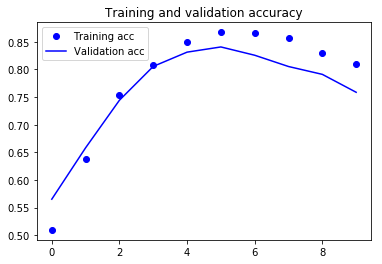

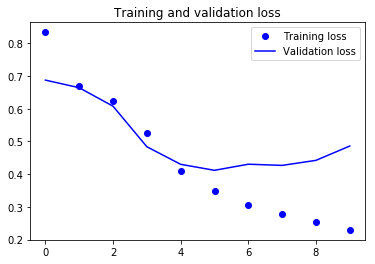

In [8]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Combining CNNs and RNNs to process long sequences

In [9]:
import os
import numpy as np

data_dir = './data/Chapter 6.3 - Advanced use of recurrent neural networks/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

# Reading the CSV file
f = open(fname)
data = f.read()
f.close()

# Splitting the file line by line
lines = data.split('\n')
# Splitting the line by comma
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
# Generator
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [12]:
train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step, 
                      batch_size = batch_size)
val_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 200001,
                    max_index = 300000,
                    step = step,
                    batch_size = batch_size)
test_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step,
                     batch_size = batch_size)

In [13]:
# Number of step to be drawn to see whole validation dataset
val_steps = (300000 - 200001 - lookback) // batch_size

# Number of step to be drawn to see whole test dataset
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Conv1D Model

In [14]:
model = Sequential()
model.add(Conv1D(filters = 32, 
                 kernel_size = 7, 
                 activation = 'relu', 
                 input_shape = (None, float_data.shape[-1])))
model.add(MaxPooling1D(pool_size = 3))
model.add(Conv1D(filters = 32, 
                 kernel_size = 5, 
                 activation = 'relu'))
model.add(MaxPooling1D(pool_size = 3))
model.add(Conv1D(filters = 32, 
                 kernel_size = 5, 
                 activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units = 1))

model.summary()

model.compile(optimizer = RMSprop(),
              loss = 'mae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          3168      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total para

In [15]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 18s 35ms/step - loss: 0.4182 - val_loss: 0.4301
Epoch 2/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3587 - val_loss: 0.4368
Epoch 3/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3333 - val_loss: 0.4383
Epoch 4/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3184 - val_loss: 0.4525
Epoch 5/20
500/500 [==============================] - 17s 34ms/step - loss: 0.3034 - val_loss: 0.4458
Epoch 6/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2966 - val_loss: 0.4567
Epoch 7/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2885 - val_loss: 0.4574
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2832 - val_loss: 0.4712
Epoch 9/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2756 - val_loss: 0.4634
Epoch 10/20
500/500 [==============================] - 17s 34ms/step - loss: 0.271

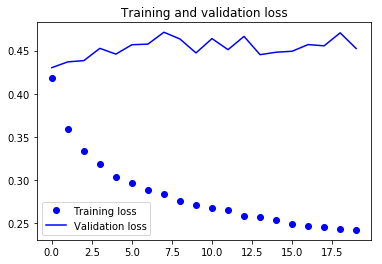

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Convolutional and Recurrent Layers Combined

In [18]:
from keras.layers import GRU

In [20]:
model = Sequential()
model.add(Conv1D(filters = 32, 
                 kernel_size = 7, 
                 activation = 'relu', 
                 input_shape = (None, float_data.shape[-1])))
model.add(MaxPooling1D(pool_size = 3))
model.add(Conv1D(filters = 32, 
                 kernel_size = 5, 
                 activation = 'relu'))
model.add(GRU(units = 32, 
              dropout = 0.1, 
              recurrent_dropout = 0.5))
model.add(Dense(units = 1))

model.summary()

model.compile(optimizer = RMSprop(),
              loss = 'mae')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, None, 32)          3168      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 14,593
Trainable params: 14,593
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 119s 238ms/step - loss: 0.3291 - val_loss: 0.2862
Epoch 2/20
500/500 [==============================] - 125s 251ms/step - loss: 0.2965 - val_loss: 0.2718
Epoch 3/20
500/500 [==============================] - 129s 258ms/step - loss: 0.2831 - val_loss: 0.2712
Epoch 4/20
500/500 [==============================] - 123s 246ms/step - loss: 0.2750 - val_loss: 0.2927
Epoch 5/20
500/500 [==============================] - 120s 241ms/step - loss: 0.2668 - val_loss: 0.2819
Epoch 6/20
500/500 [==============================] - 117s 233ms/step - loss: 0.2641 - val_loss: 0.2842
Epoch 7/20
500/500 [==============================] - 119s 239ms/step - loss: 0.2560 - val_loss: 0.2712
Epoch 8/20
500/500 [==============================] - 115s 230ms/step - loss: 0.2496 - val_loss: 0.2680
Epoch 9/20
500/500 [==============================] - 126s 251ms/step - loss: 0.2444 - val_loss: 0.2691
Epoch 10/20
500/500 [==============================] - 125s 251m

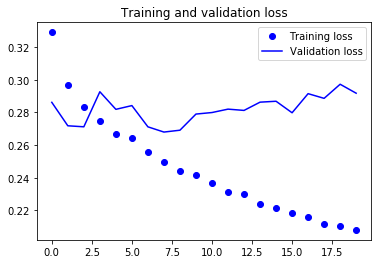

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()